### TRMM PNG monitoring

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
from mpl_toolkits.basemap import maskoceans, interp

In [2]:
import numpy as np
import pandas as pd
import xray
from netCDF4 import MFDataset
from datetime import datetime, timedelta
from glob import glob
import palettable

In [3]:
dpath = '/Users/nicolasf/data/TRMM/daily/'
climpath = '/Users/nicolasf/data/TRMM/climatology/daily/'

In [4]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xray.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    #paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in files]
    combined = xray.concat(datasets, dim)
    return combined

In [5]:
domain = {'latmin':-12., 'lonmin':140., 'latmax':0., 'lonmax':160.}

In [6]:
today = datetime.utcnow()

### lag is the lag in days

In [7]:
lag = 2

### ndays is the number of days to retrieve (i.e. last 30 days, last 60 days, etc)

In [8]:
ndays = 30

### get the current TRMM date

In [9]:
trmm_date = today - timedelta(days=lag)

### creates the list of days 

In [10]:
realtime = pd.date_range(start=trmm_date - timedelta(days=ndays-1), end=trmm_date)

In [11]:
print("calculating realtime data for {:%Y-%m-%d} to {:%Y-%m-%d}".format(realtime[0], realtime[-1]))

calculating realtime data for 2015-09-18 to 2015-10-17


In [12]:
lfiles = []
for d in realtime: 
    fname  = dpath + "3B42RT_daily.{}.nc".format(d.strftime("%Y.%m.%d"))
    lfiles.append(fname)

### reads the files

In [13]:
dset_realtime = read_netcdfs(lfiles, 'time')

### selects the domain

In [14]:
dset_realtime = dset_realtime.sel(lat=slice(domain['latmin'], domain['latmax']), \
                                  lon=slice(domain['lonmin'], domain['lonmax']))

### reads the climatology

In [15]:
clim_files = []
for d in realtime: 
    fname  = climpath + "3B42_daily.{}.nc".format(d.strftime("%m.%d"))
    clim_files.append(fname)

In [16]:
dset_clim = read_netcdfs(clim_files, 'time')

In [17]:
dset_clim = dset_clim.sel(latitude=slice(domain['latmin'], domain['latmax']), \
                          longitude=slice(domain['lonmin'], domain['lonmax']))

In [18]:
clim_ave = dset_clim.mean('time')
clim_sum = dset_clim.sum('time')

In [19]:
clim_ave

<xray.Dataset>
Dimensions:    (latitude: 48, longitude: 80)
Coordinates:
  * latitude   (latitude) float64 -11.88 -11.62 -11.38 -11.12 -10.88 -10.62 ...
  * longitude  (longitude) float64 140.1 140.4 140.6 140.9 141.1 141.4 141.6 ...
Data variables:
    hrf        (latitude, longitude) float64 0.564 0.6508 0.6209 0.6048 ...

In [20]:
realtime_ave = dset_realtime.mean('time')
realtime_sum = dset_realtime.sum('time')

In [21]:
realtime_ave

<xray.Dataset>
Dimensions:  (lat: 48, lon: 80)
Coordinates:
  * lon      (lon) float32 140.125 140.375 140.625 140.875 141.125 141.375 ...
  * lat      (lat) float32 -11.875 -11.625 -11.375 -11.125 -10.875 -10.625 ...
Data variables:
    trmm     (lat, lon) float64 0.143 0.142 0.03 0.014 0.038 0.045 0.245 ...

In [22]:
realtime_ave['clim'] = (['lat','lon'], clim_ave['hrf'].data)
realtime_sum['clim'] = (['lat','lon'], clim_sum['hrf'].data)

### calculates the anomalies

In [23]:
anoms = realtime_ave['trmm'] - realtime_ave['clim']

In [24]:
anomsp = ((realtime_ave['trmm'] - realtime_ave['clim']) / realtime_ave['clim']) * 100.

In [25]:
pp = realtime_sum['trmm'] / realtime_sum['clim'] * 100.

### gets the cmap

In [26]:
cmap = palettable.colorbrewer.diverging.BrBG_11.mpl_colormap

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


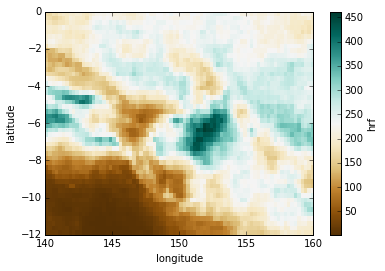

In [27]:
clim_sum['hrf'].plot(yincrease=True, cmap=cmap)

In [28]:
lat = anoms.lat
lon = anoms.lon

In [29]:
lons, lats = np.meshgrid(lon, lat)

In [30]:
topo = maskoceans(lons, lats, pp.data)

In [31]:
map = bm(projection='cyl', llcrnrlon=domain['lonmin']+0.25, \
              llcrnrlat=domain['latmin']+0.25, \
              urcrnrlon=domain['lonmax']-0.25, \
              urcrnrlat=domain['latmax']-0.25, resolution='f')

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


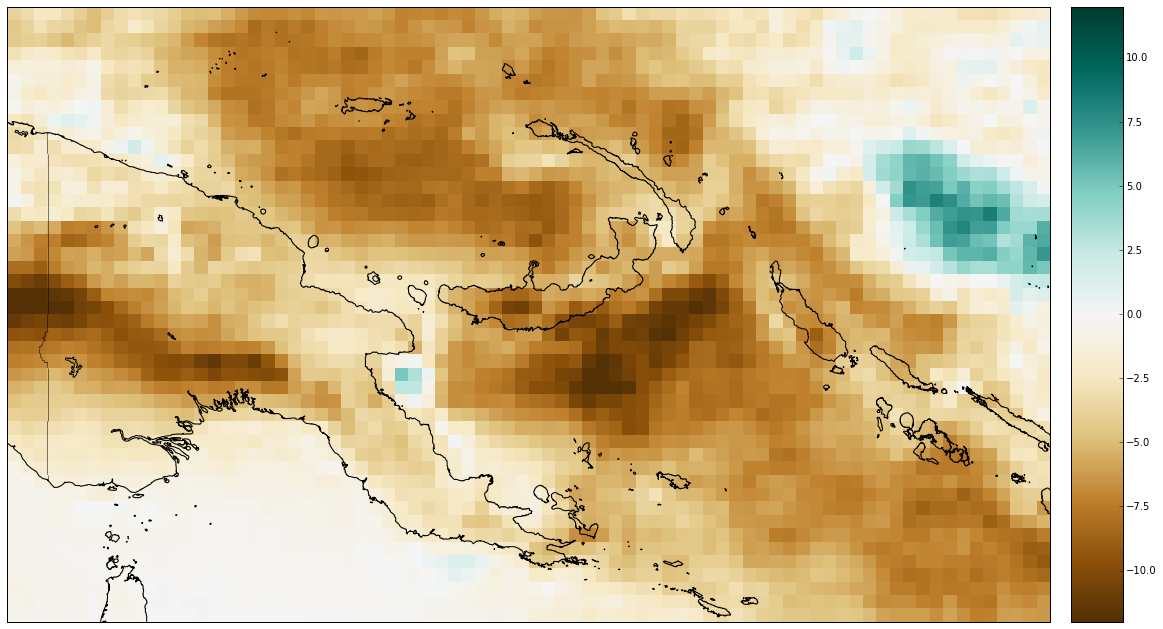

In [32]:
f, ax = plt.subplots(figsize=(20,20))
map.ax = ax
map.drawcoastlines()
map.drawcountries()
# map.contourf(lons, lats, topo, np.arange(-12, 13, 1), latlon=True, cmap=cmap, extend='both')
map.pcolor(lons-0.125, lats-0.125, topo, latlon=True, cmap=cmap, vmin=-12, vmax=12, snap=True)
im = map.pcolor(lons-0.125, lats-0.125, anoms.data, latlon=True, cmap=cmap, vmin=-12, vmax=12, snap=True)
im = map.pcolor(lons-0.125, lats-0.125, anoms.data, latlon=True, cmap=cmap, vmin=-12, vmax=12, snap=True)
map.colorbar(im)

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


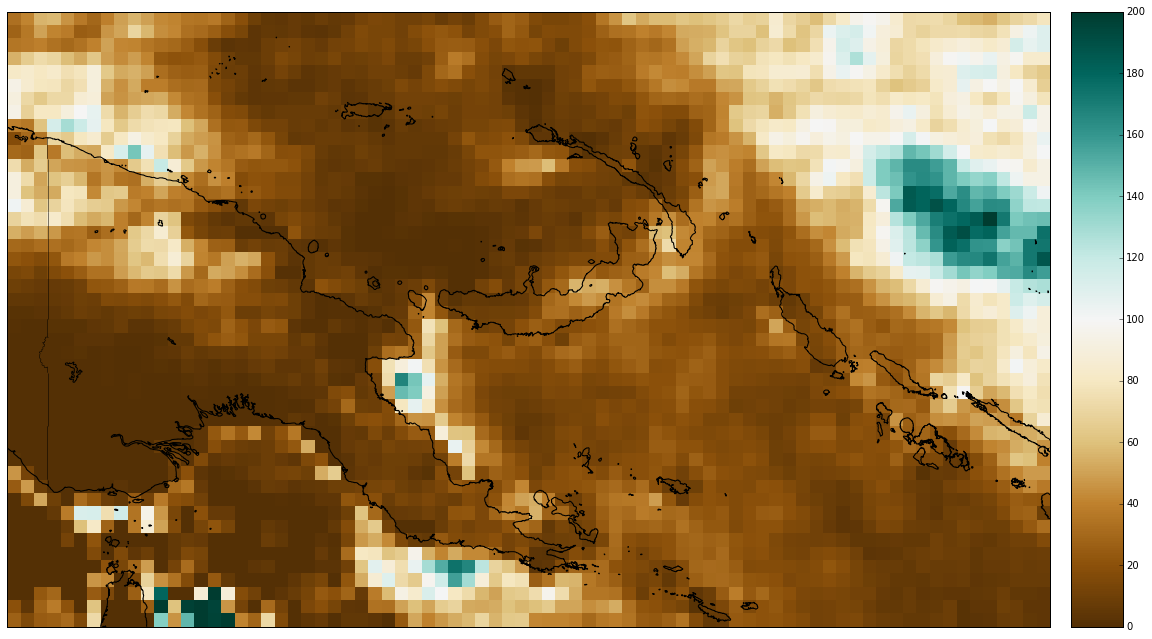

In [33]:
f, ax = plt.subplots(figsize=(20,20))
map.ax = ax
map.drawcoastlines()
map.drawcountries()
# map.contourf(lons, lats, topo, np.arange(-12, 13, 1), latlon=True, cmap=cmap, extend='both')
im = map.pcolor(lons-0.125, lats-0.125, pp.data, latlon=True, cmap=cmap, vmin=0, vmax=200, snap=True)
map.colorbar(im)

In [34]:
ppm = maskoceans(lons, lats, pp.data)

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


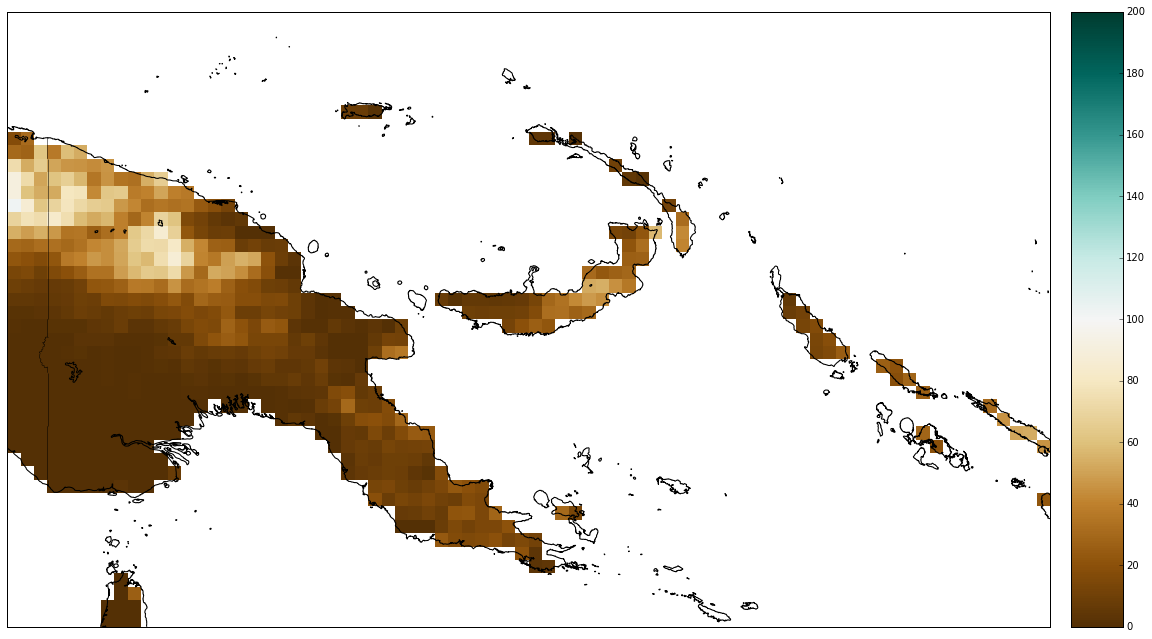

In [35]:
f, ax = plt.subplots(figsize=(20,20))
map.ax = ax
map.drawcoastlines()
map.drawcountries()
# map.contourf(lons, lats, topo, np.arange(-12, 13, 1), latlon=True, cmap=cmap, extend='both')
im = map.pcolor(lons-0.125, lats-0.125, ppm, latlon=True, cmap=cmap, vmin=0, vmax=200, snap=True)
map.colorbar(im)

In [36]:
vmin=-10
vmax=10
step=1

In [37]:
cities = {}
cities['Port Moresby'] = (-9.513639, 147.218806)
cities['Lae'] = (-6.73333, 147)
cities['Alotau'] = (-10.316667, 150.433333)
cities['Daru'] = (-9.083333, 143.2)
cities['Madang'] = (-5.216667, 145.8)
cities['Wewak'] = (-3.55, 143.633333)

In [38]:
def plot_cities(ax, cities): 
    for k in cities: 
        ax.plot(cities[k][1],cities[k][0], 'ro', transform=ax.transData)
        ax.text(cities[k][1]+0.1,cities[k][0]+0.1, k, transform=ax.transData, fontsize=14, color='#0B0B61')

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


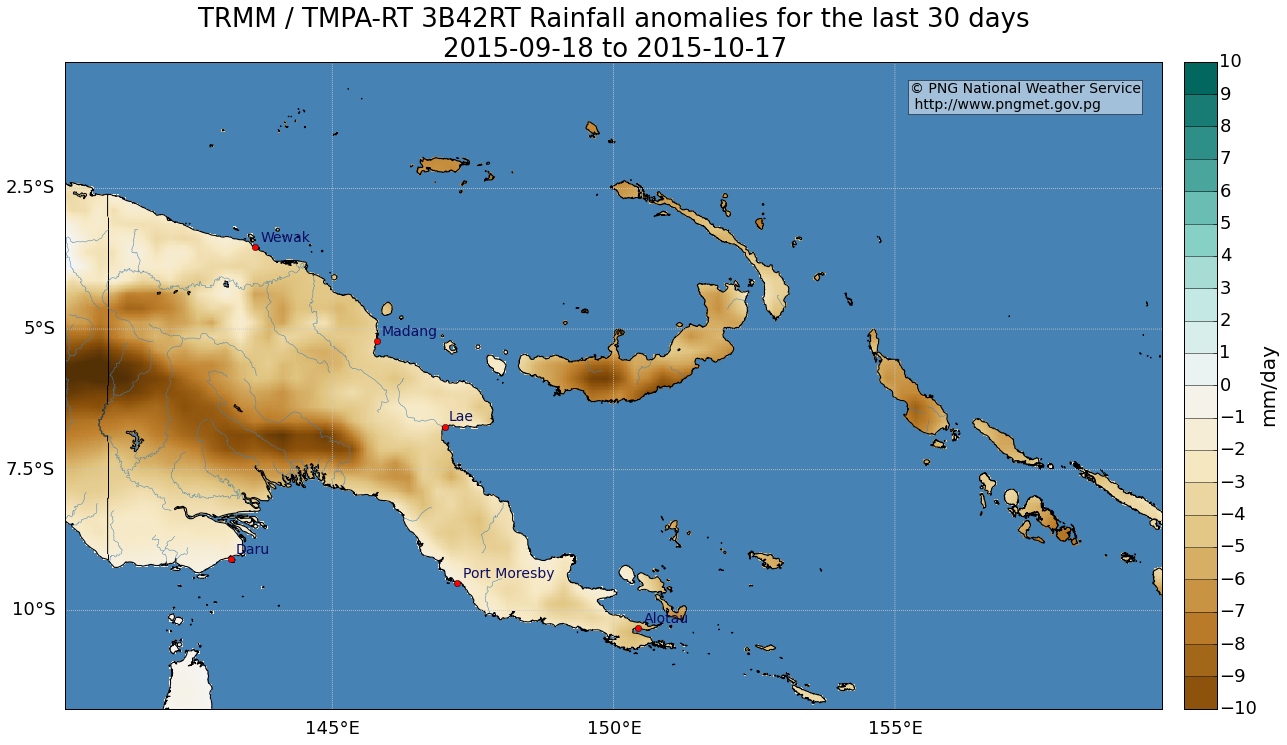

In [39]:
nlats = 10*anoms.data.shape[0]
nlons = 10*anoms.data.shape[1]
lons = np.linspace(float(min(lon)),float(max(lon)),nlons)
lats = np.linspace(float(min(lat)),float(max(lat)),nlats)
lons, lats = np.meshgrid(lons, lats)

offset = np.diff(lons)[0][0] / 2.
# offset = 0

x, y = map(lons-offset, lats-offset)
topo = interp(anoms.data,lon.data.flatten(),lat.data.flatten(),lons,lats,order=1)
# interpolate land/sea mask to topo grid, mask ocean values.
topom = maskoceans(lons, lats, topo, resolution='f', grid=1.25)
# make contour plot (ocean values will be masked)

f, ax = plt.subplots(figsize=(20,20 * np.divide(*topo.shape)))
f.subplots_adjust(left=0.1)

map.ax = ax
map.drawcoastlines(color='k')
map.drawcountries(linewidth=1)

meridians = np.arange(140., 160., 5)
parallels = np.arange(-10., 0., 2.5)

map.drawparallels(parallels, labels=[1,0,0,0], fontsize=18, linewidth=0.8, color='.8')
map.drawmeridians(meridians, labels=[0,0,0,1], fontsize=18, linewidth=0.8, color='.8')

map.drawrivers(color='steelblue')


CS=map.pcolor(x,y,topom,cmap=cmap,vmin=-12,vmax=12, snap=False)

map.drawmapboundary(fill_color='steelblue')
text = u'\N{Copyright Sign}' + ' PNG National Weather Service \n http://www.pngmet.gov.pg'
ax.text(0.77,0.9275, text, transform = ax.transAxes, fontdict={'size':14}, bbox=dict(facecolor='w', alpha=0.5))
cb = map.colorbar(CS, location='right', ticks=np.arange(vmin,vmax+step, step), size="3%", boundaries=np.arange(vmin,vmax+step, step),\
            drawedges=True)
[l.set_fontsize(18) for l in cb.ax.get_yticklabels()]; 
cb.set_label('mm/day', fontsize=20)
ax.set_title('TRMM / TMPA-RT 3B42RT Rainfall anomalies for the last {} days\n\
{:%Y-%m-%d} to {:%Y-%m-%d}'.format(ndays, realtime[0], \
            realtime[-1]), fontsize=26)

plot_cities(ax, cities)

In [40]:
f.savefig('../images/last{}days_maskocean_mm.png'.format(ndays), dpi=200)

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [41]:
vmin=0
vmax=20
step=1

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


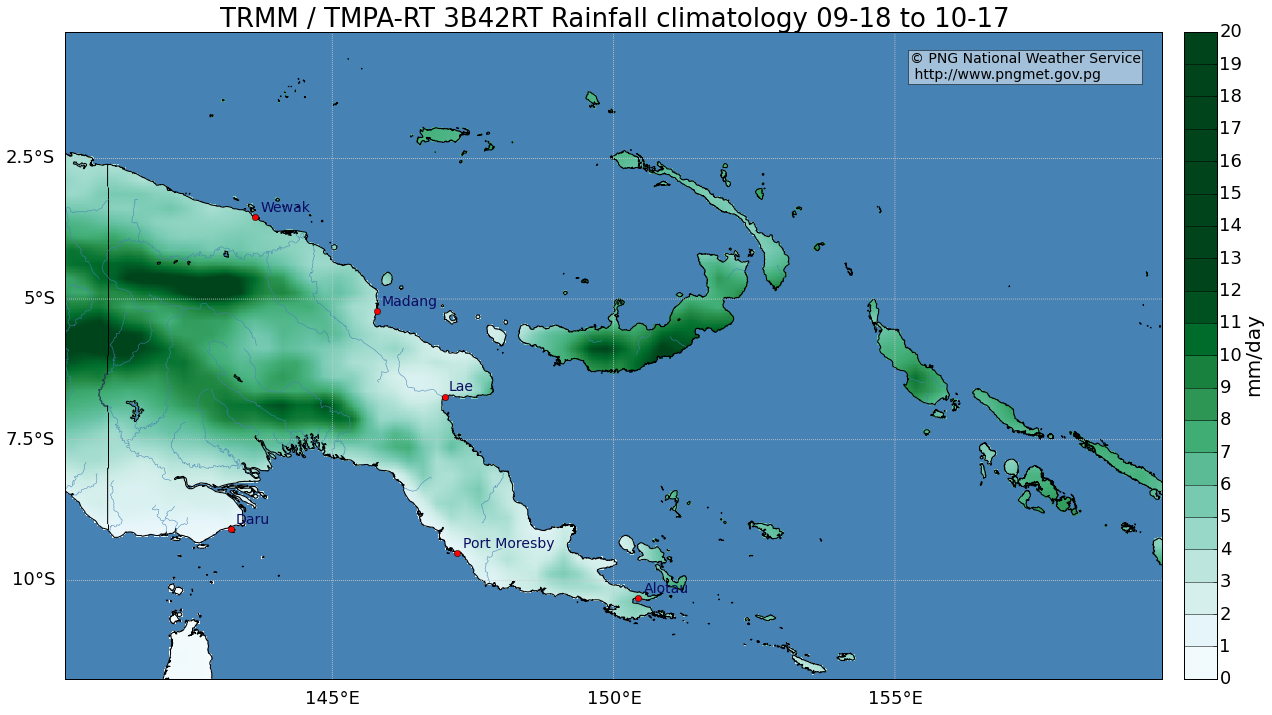

In [42]:
nlats = 10*anoms.data.shape[0]
nlons = 10*anoms.data.shape[1]
lons = np.linspace(float(min(lon)),float(max(lon)),nlons)
lats = np.linspace(float(min(lat)),float(max(lat)),nlats)
lons, lats = np.meshgrid(lons, lats)

offset = np.diff(lons)[0][0] / 2.
# offset = 0

x, y = map(lons-offset, lats-offset)
topo = interp(realtime_ave['clim'].data,lon.data.flatten(),lat.data.flatten(),lons,lats,order=1)
# interpolate land/sea mask to topo grid, mask ocean values.
topom = maskoceans(lons, lats, topo, resolution='f', grid=1.25)
# make contour plot (ocean values will be masked)

f, ax = plt.subplots(figsize=(20,20 * np.divide(*topo.shape)))
f.subplots_adjust(left=0.1)

map.ax = ax
map.drawcoastlines(color='k')
map.drawcountries(linewidth=1)

meridians = np.arange(140., 160., 5)
parallels = np.arange(-10., 0., 2.5)

map.drawparallels(parallels, labels=[1,0,0,0], fontsize=18, linewidth=0.8, color='.8')
map.drawmeridians(meridians, labels=[0,0,0,1], fontsize=18, linewidth=0.8, color='.8')

map.drawrivers(color='steelblue')


CS=map.pcolor(x,y,topom,cmap=plt.get_cmap('BuGn'),vmin=0,vmax=12, snap=False)

map.drawmapboundary(fill_color='steelblue')
text = u'\N{Copyright Sign}' + ' PNG National Weather Service \n http://www.pngmet.gov.pg'
ax.text(0.77,0.9275, text, transform = ax.transAxes, fontdict={'size':14}, bbox=dict(facecolor='w', alpha=0.5))
cb = map.colorbar(CS, location='right', ticks=np.arange(vmin,vmax+step, step), size="3%", boundaries=np.arange(vmin,vmax+step, step),\
            drawedges=True)
[l.set_fontsize(18) for l in cb.ax.get_yticklabels()]; 
cb.set_label('mm/day', fontsize=20)
ax.set_title('TRMM / TMPA-RT 3B42RT Rainfall climatology {:%m-%d} to {:%m-%d}'.format(realtime[0], \
            realtime[-1]), fontsize=26)

plot_cities(ax, cities)

In [43]:
f.savefig('../images/realtime_maskocean_CLIM_{}.png'.format(ndays), dpi=200)

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [44]:
vmin=0
vmax=200
step=10

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


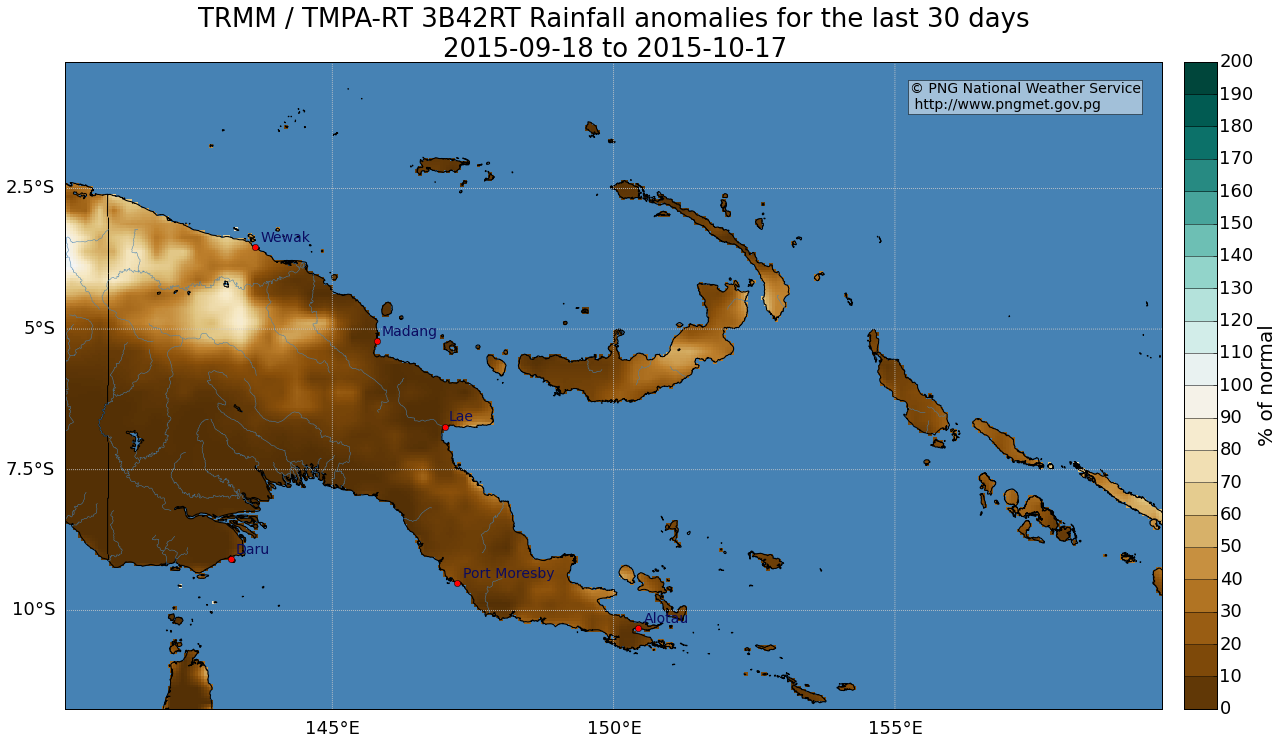

In [45]:
nlats = 5*pp.data.shape[0]
nlons = 5*pp.data.shape[1]
lons = np.linspace(float(min(lon)),float(max(lon)),nlons)
lats = np.linspace(float(min(lat)),float(max(lat)),nlats)
lons, lats = np.meshgrid(lons, lats)

offset = np.diff(lons)[0][0] / 2.
# offset = 0

x, y = map(lons-offset, lats-offset)
topo = interp(pp.data,lon.data.flatten(),lat.data.flatten(),lons,lats,order=1)
# interpolate land/sea mask to topo grid, mask ocean values.
topom = maskoceans(lons, lats, topo, resolution='f', grid=1.25)
# make contour plot (ocean values will be masked)

f, ax = plt.subplots(figsize=(20,20 * np.divide(*topo.shape)))
f.subplots_adjust(left=0.1)

map.ax = ax
map.drawcoastlines(color='k')
map.drawcountries(linewidth=1)

meridians = np.arange(140., 160., 5)
parallels = np.arange(-10., 0., 2.5)

map.drawparallels(parallels, labels=[1,0,0,0], fontsize=18, linewidth=0.8, color='.8')
map.drawmeridians(meridians, labels=[0,0,0,1], fontsize=18, linewidth=0.8, color='.8')

map.drawrivers(color='steelblue')


CS=map.pcolor(x,y,topom,cmap=cmap,vmin=vmin,vmax=vmax, snap=False)

map.drawmapboundary(fill_color='steelblue')
text = u'\N{Copyright Sign}' + ' PNG National Weather Service \n http://www.pngmet.gov.pg'
ax.text(0.77,0.9275, text, transform = ax.transAxes, fontdict={'size':14}, bbox=dict(facecolor='w', alpha=0.5))
cb = map.colorbar(CS, location='right', ticks=np.arange(vmin,vmax+step, step), size="3%", boundaries=np.arange(vmin,vmax+step, step),\
            drawedges=True)
[l.set_fontsize(18) for l in cb.ax.get_yticklabels()]; 
cb.set_label('% of normal', fontsize=20)
ax.set_title('TRMM / TMPA-RT 3B42RT Rainfall anomalies for the last {} days\n\
{:%Y-%m-%d} to {:%Y-%m-%d}'.format(ndays, realtime[0], \
            realtime[-1]), fontsize=26)

plot_cities(ax, cities)

In [46]:
f.savefig('../images/last{}days_maskocean_pp.png'.format(ndays), dpi=200)

/Users/nicolasf/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [47]:
dset_realtime.close()
dset_clim.close()